# Prediction of sales

In [143]:
#importing important libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

In [144]:
#Kaggle divides the dataset already into Train and Test data
locationpath="C:/Users/u_je_/GoogleDrive/Personal/Work/Online/Jupyter/Git/Black friday Analysis Github repository/Black_Friday_data_analysis/black friday/Data Test"
train = pd.read_csv(locationpath+"/train.csv")
test = pd.read_csv(locationpath+"/test.csv")

In [145]:
# some information on data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [146]:
# understanding how many unique values i have
for col_name in train.columns:
    print(col_name, len(train[col_name].unique()))

User_ID 5891
Product_ID 3631
Gender 2
Age 7
Occupation 21
City_Category 3
Stay_In_Current_City_Years 5
Marital_Status 2
Product_Category_1 20
Product_Category_2 18
Product_Category_3 16
Purchase 18105


In [147]:
# getting the values of every unique entry from the following possible features 
for col_name in ['Gender', 'Age', 'Occupation', 'City_Category','Stay_In_Current_City_Years','Marital_Status']:
    print(sorted(train[col_name].unique()))

['F', 'M']
['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['A', 'B', 'C']
['0', '1', '2', '3', '4+']
[0, 1]


In [148]:
# checking if unique users have consistant information in all of their enteries 
temp = train.drop_duplicates('User_ID')
print(temp.count())
df2 = train.drop(['Purchase','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
df3 = df2.drop_duplicates()
df3.count()

User_ID                       5891
Product_ID                    5891
Gender                        5891
Age                           5891
Occupation                    5891
City_Category                 5891
Stay_In_Current_City_Years    5891
Marital_Status                5891
Product_Category_1            5891
Product_Category_2            4097
Product_Category_3            1914
Purchase                      5891
dtype: int64


User_ID                       5891
Gender                        5891
Age                           5891
Occupation                    5891
City_Category                 5891
Stay_In_Current_City_Years    5891
Marital_Status                5891
dtype: int64

# Descriptive analysis and Data Exploration 

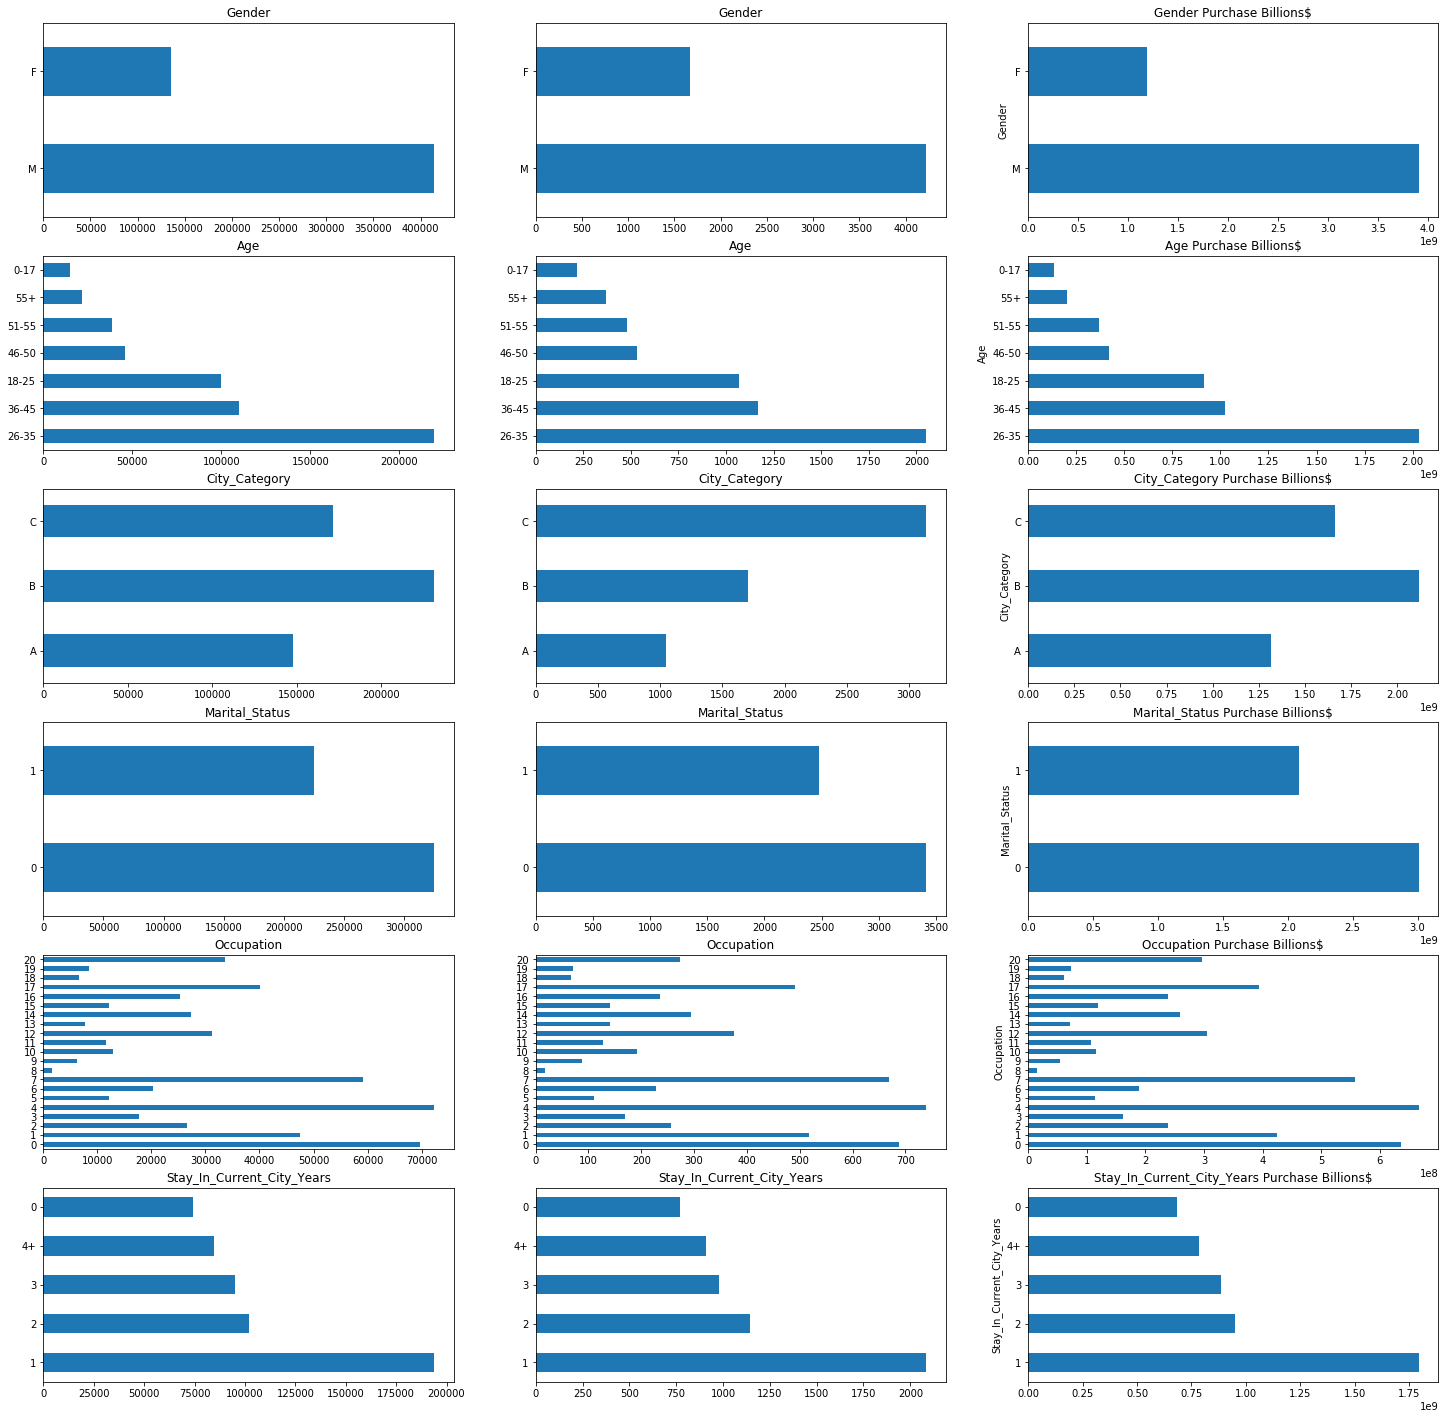

In [149]:
# lets compare the counts of entiers and unique users and the amount of purchases 
Train_unique= train.drop_duplicates('User_ID')
# Second for each unique group, we do a group by to sum the purchase amount
dfGender = train.groupby(['Gender'])['Purchase'].sum()
dfage = train.groupby(['Age'])['Purchase'].sum()
dfoccu = train.groupby(['Occupation'])['Purchase'].sum()
dfCC = train.groupby(['City_Category'])['Purchase'].sum()
dfstay = train.groupby(['Stay_In_Current_City_Years'])['Purchase'].sum()
dfM = train.groupby(['Marital_Status'])['Purchase'].sum()


fig, axes = plt.subplots(nrows=6, ncols=3, figsize=[25, 25])

# count of eneries 
train['Gender'].value_counts().plot(kind='barh', ax=axes[0,0], title='Gender')
train['Age'].value_counts().plot(kind='barh', ax=axes[1,0], title='Age')
train['City_Category'].value_counts().sort_index().plot(kind='barh', ax=axes[2,0], title='City_Category')
train['Marital_Status'].value_counts().plot(kind='barh', ax=axes[3,0], title='Marital_Status')
train['Occupation'].value_counts().sort_index().plot(kind='barh', ax=axes[4,0], title='Occupation')
train['Stay_In_Current_City_Years'].value_counts().plot(kind='barh', ax=axes[5,0], title='Stay_In_Current_City_Years')
# unique user count
Train_unique['Gender'].value_counts().plot(kind='barh', ax=axes[0,1], title='Gender')
Train_unique['Age'].value_counts().plot(kind='barh', ax=axes[1,1], title='Age')
Train_unique['City_Category'].value_counts().sort_index().plot(kind='barh', ax=axes[2,1], title='City_Category')
Train_unique['Marital_Status'].value_counts().plot(kind='barh', ax=axes[3,1], title='Marital_Status')
Train_unique['Occupation'].value_counts().sort_index().plot(kind='barh', ax=axes[4,1], title='Occupation')
Train_unique['Stay_In_Current_City_Years'].value_counts().plot(kind='barh', ax=axes[5,1], title='Stay_In_Current_City_Years')
# amount of purchaes 
dfGender.sort_values(ascending=False).plot(kind='barh', ax=axes[0,2], title='Gender Purchase Billions$')
dfage.sort_values(ascending=False).plot(kind='barh', ax=axes[1,2], title='Age Purchase Billions$')
dfCC.sort_index().plot(kind='barh', ax=axes[2,2], title='City_Category Purchase Billions$')
dfM.sort_values(ascending=False).plot(kind='barh', ax=axes[3,2], title='Marital_Status Purchase Billions$')
dfoccu.sort_index().plot(kind='barh', ax=axes[4,2], title='Occupation Purchase Billions$')
dfstay.sort_values(ascending=False).plot(kind='barh', ax=axes[5,2], title='Stay_In_Current_City_Years Purchase Billions$')


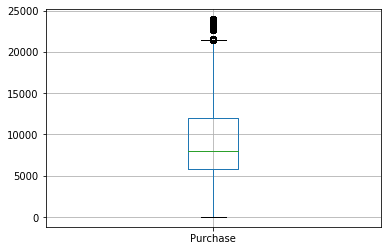

In [150]:
boxplot = train.boxplot(column='Purchase')

In [151]:
#finding outliers
Q1 = train['Purchase'].quantile(0.25)
Q3 = train['Purchase'].quantile(0.75)
IQR = Q3 - Q1
outliers=train[(train['Purchase'] < Q1-1.5*IQR ) | (train['Purchase'] > Q3+1.5*IQR)]['Purchase']
Outlier_index=outliers.reset_index().drop(['Purchase'], axis=1)
oil=Outlier_index["index"].tolist()
Purchase_outliers=train.loc[Outlier_index['index']]
train_nooutliers=train.drop(index=oil,axis=0)

# Pre-Processing 

In [152]:
#because i have categorical data in many columns i need to change them to dummy binary or int 
train['Product_Category_2']=train['Product_Category_2'].fillna(-2.0).astype("int64")
train['Product_Category_3']=train['Product_Category_3'].fillna(-2.0).astype("int64")
test['Product_Category_2']=test['Product_Category_2'].fillna(-2.0).astype("int64")
test['Product_Category_3']=test['Product_Category_3'].fillna(-2.0).astype("int64")

In [153]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#Turn gender into binary
gender_dict = {'F':0, 'M':1}
train["Gender"] = train["Gender"].apply(lambda line: gender_dict[line])

In [154]:
# Giving Age groups Numerical values
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
train["Age"] = train["Age"].apply(lambda line: age_dict[line])

In [155]:
city_dict = {'A':0, 'B':1, 'C':2}
train["City_Category"] = train["City_Category"].apply(lambda line: city_dict[line])

In [156]:
#New variable for outlet
train['Stay_In_Current_City_Years'] = le.fit_transform(train['Stay_In_Current_City_Years'])
#Dummy Variables:
train = pd.get_dummies(train, columns=['Stay_In_Current_City_Years'])
train.drop(train.columns[len(train.columns)-1], axis=1, inplace=True)

In [157]:
#Turn gender binary
gender_dict = {'F':0, 'M':1}
test["Gender"] = test["Gender"].apply(lambda line: gender_dict[line])
test["Gender"].value_counts()
# Giving Age Numerical values
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
test["Age"] = test["Age"].apply(lambda line: age_dict[line])
test["Age"].value_counts()
city_dict = {'A':0, 'B':1, 'C':2}
test["City_Category"] = test["City_Category"].apply(lambda line: city_dict[line])
test["City_Category"].value_counts()
le = LabelEncoder()

In [158]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
test['Stay_In_Current_City_Years'] = le.fit_transform(test['Stay_In_Current_City_Years'])
#Dummy Variables:
test = pd.get_dummies(test, columns=['Stay_In_Current_City_Years'])
test.drop(test.columns[len(test.columns)-1], axis=1, inplace=True)

,User_ID,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3
User_ID,1.000000,-0.033474,0.032698,-0.023971,0.022859,0.020443,0.003825,0.004049,0.003572,0.004716,0.006495,0.019574,0.018551,-0.030953
Gender,-0.033474,1.000000,-0.004262,0.117291,-0.004515,-0.011603,-0.045594,0.000859,0.036014,0.060346,0.016094,-0.030400,0.008806,-0.011080
Age,0.032698,-0.004262,1.000000,0.091463,0.123079,0.311738,0.061197,0.014684,-0.009120,0.015839,-0.022994,0.039493,-0.018286,-0.012848
Occupation,-0.023971,0.117291,0.091463,1.000000,0.034479,0.024280,-0.007618,0.007284,0.012114,0.020833,-0.026055,-0.002092,-0.012716,0.025974
City_Category,0.022859,-0.004515,0.123079,0.034479,1.000000,0.039790,-0.014364,0.018480,0.036202,0.061914,-0.040678,0.017688,0.009208,-0.006805
Marital_Status,0.020443,-0.011603,0.311738,0.024280,0.039790,1.000000,0.019888,-0.000357,-0.005248,-0.000463,-0.010673,0.028831,-0.006474,-0.013635
Product_Category_1,0.003825,-0.045594,0.061197,-0.007618,-0.014364,0.019888,1.000000,-0.119386,-0.396342,-0.343703,0.004576,0.006121,-0.007000,-0.010995
Product_Category_2,0.004049,0.000859,0.014684,0.007284,0.018480,-0.000357,-0.119386,1.000000,0.133635,0.078570,-0.003272,0.001100,0.001205,-0.000029
Product_Category_3,0.003572,0.036014,-0.009120,0.012114,0.036202,-0.005248,-0.396342,0.133635,1.000000,0.294086,-0.001956,-0.003518,0.004995,0.003486
Purchase,0.004716,0.060346,0.015839,0.020833,0.061914,-0.000463,-0.343703,0.078570,0.294086,1.000000,-0.006605,-0.002030,0.005358,0.002090


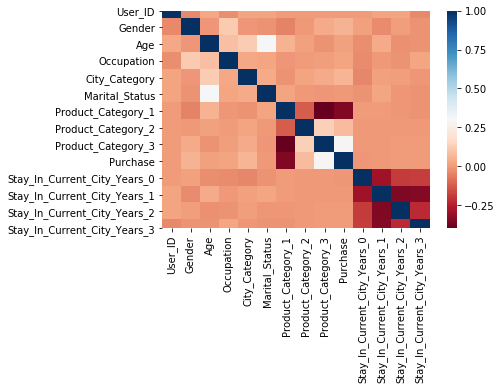

In [159]:
# calculate the correlation matrix
corr = train.corr()

# display the correlation matrix
display(corr)

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

# model coding

In [161]:
#Define target and ID columns:
target = 'Purchase'
IDcol = ['User_ID','Product_ID']
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors],(dtrain[target]) , cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error((dtrain[target]).values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(
        r"C:/Users/u_je_/GoogleDrive/Personal/Work/Online/Jupyter/Git/Black friday Analysis Github repository/Black_Friday_data_analysis/black friday/output/test1.csv",index=False)

# Verbatum model

In [118]:
model =LinearRegression()
predictorsdata=train.drop(['Purchase','Product_ID','User_ID'],axis=1)
try:
    testdata=test.drop(['Purchase','Product_ID','User_ID'],axis=1)
except:
    testdata=test.drop(['Product_ID','User_ID'],axis=1)
model.fit(predictorsdata,train['Purchase'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [119]:
predictorsdata.shape

(550068, 12)

In [120]:
testdata.shape

(233599, 12)

In [121]:
model.coef_

array([ 476.89923727,  106.46811006,    5.72931717,  314.13832447,
        -48.1790819 , -342.17338993,   15.10833981,  128.46571455,
        -51.88545985,  -17.73745919,    9.27006316,  -21.98158466])

In [122]:
model.intercept_

9742.739609756192

In [123]:
predictiontest=model.predict(testdata)

In [124]:
test

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3
0,1000004,P00128942,1,4,7,1,1,1,11,-2,0,0,1,0
1,1000009,P00113442,1,2,17,2,0,3,5,-2,1,0,0,0
2,1000010,P00288442,0,3,1,1,1,5,14,-2,0,0,0,0
3,1000010,P00145342,0,3,1,1,1,4,9,-2,0,0,0,0
4,1000011,P00053842,0,2,1,2,0,4,5,12,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233594,1006036,P00118942,0,2,15,1,1,8,-2,-2,0,0,0,0
233595,1006036,P00254642,0,2,15,1,1,5,8,-2,0,0,0,0
233596,1006036,P00031842,0,2,15,1,1,1,5,12,0,0,0,0
233597,1006037,P00124742,0,4,1,2,0,10,16,-2,0,0,0,0


In [125]:
test.shape

(233599, 14)

In [126]:
test.insert(11,'Purchase',predictiontest)

In [127]:
test

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Stay_In_Current_City_Years_0,Purchase,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3
0,1000004,P00128942,1,4,7,1,1,1,11,-2,0,10527.932732,0,1,0
1,1000009,P00113442,1,2,17,2,0,3,5,-2,1,9898.454748,0,0,0
2,1000010,P00288442,0,3,1,1,1,5,14,-2,0,8577.550878,0,0,0
3,1000010,P00145342,0,3,1,1,1,4,9,-2,0,8844.182569,0,0,0
4,1000011,P00053842,0,2,1,2,0,4,5,12,0,10820.381051,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233594,1006036,P00118942,0,2,15,1,1,8,-2,-2,0,7283.039602,0,0,0
233595,1006036,P00254642,0,2,15,1,1,5,8,-2,0,8460.643170,0,0,0
233596,1006036,P00031842,0,2,15,1,1,1,5,12,0,11582.531714,0,0,0
233597,1006037,P00124742,0,4,1,2,0,10,16,-2,0,7365.686125,0,0,0


In [128]:
#Export submission file:
#test.to_csv(
#    r"C:/Users/u_je_/GoogleDrive/Personal/Work/Online/Jupyter/Git/Black friday Analysis Github repository/Black_Friday_data_analysis/black friday/output/test1.csv",index=False)

In [129]:
# Model Selection


Model Report
RMSE : 4622
CV Score : Mean - 4625 | Std - 33.24 | Min - 4557 | Max - 4680


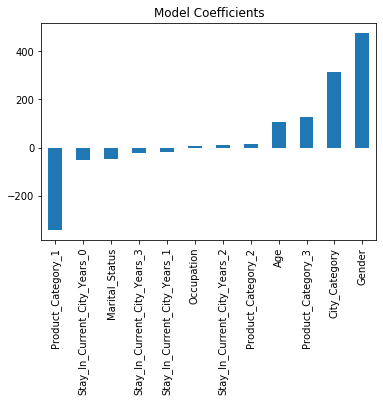

In [130]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression(normalize=True)

predictors = train.columns.drop(['Purchase','Product_ID','User_ID'])
modelfit(LR, train, test, predictors, target, IDcol, 'LR.csv')

coef1 = pd.Series(LR.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 2983
CV Score : Mean - 2998 | Std - 20.42 | Min - 2959 | Max - 3034


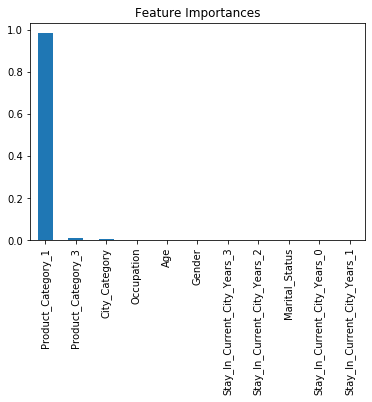

In [138]:
from sklearn.tree import DecisionTreeRegressor
RF = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
predictors = train.columns.drop(['Purchase','Product_ID','User_ID','Product_Category_2'])
modelfit(RF, train, test, predictors, target, IDcol, 'RF.csv')

coef4 = pd.Series(RF.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

In [140]:
!pip install xgboost

In [162]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train[predictors], train[target], early_stopping_rounds=5, 
             eval_set=[(train[predictors], train[target])], verbose=False)
#Predict training set:
train_predictions = my_model.predict(train[predictors])

# make predictions
predictions = my_model.predict(test[predictors])

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test[target])))
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error((train[target]).values, train_predictions)))
IDcol.append(target)
submission = pd.DataFrame({ x: test_df[x] for x in IDcol})
submission.to_csv(
    r"C:/Users/u_je_/GoogleDrive/Personal/Work/Online/Jupyter/Git/Black friday Analysis Github repository/Black_Friday_data_analysis/black friday/output/test1.csv",index=False)

KeyError: 'Purchase'